In [64]:
import numpy as np
import scipy as sp
import torch
import matplotlib.pyplot as plt

In [65]:
inversionFree = True
constrained = True

c = torch.randn((100, 1), requires_grad=False)
d = torch.randn((100, 1), requires_grad=False)


def f(x, y):
    return torch.sin(c.T @ x + d.T @ y) + torch.log(torch.linalg.norm(x+y)**2 + 1)

def g(x, y):
    return 0.5 * torch.linalg.norm(x-y)**2


if constrained:
    A = torch.randn((100, 100), requires_grad=False)
    H = torch.randn((100, 100), requires_grad=False) 

    def Lagrangian(x, z):
        y = z[0:100]; nu = z[100:]
        return g(x, y) + nu.T @ (A@x + H@y)

In [66]:
def calc_derivatives(x, y, nu=None):
    f_val = f(x,y)
    g_val = g(x,y)

    # 1st derivatives
    dfdy = torch.autograd.grad(f_val, y, create_graph=True)[0]
    dfdx = torch.autograd.grad(f_val, x, create_graph=True)[0]

    dgdy = torch.autograd.grad(g_val, y, create_graph=True)[0]
    dgdx = torch.autograd.grad(g_val, x, create_graph=True)[0]

    # Initialize tensors for 2nd derivatives
    dgdyy = torch.zeros((100, 100))
    dgdyx = torch.zeros((100, 100))
    # Compute 2nd derivatives element-wise
    for i in range(dgdy.shape[0]):
        dgdyy[i, :] = torch.autograd.grad(dgdy[i], y, retain_graph=True, create_graph=True)[0][:, 0]
        dgdyx[i, :] = torch.autograd.grad(dgdy[i], x, retain_graph=True, create_graph=True)[0][:, 0]
    
    if nu is None:
        return dfdx, dfdy, dgdx, dgdy, dgdyy, dgdyx
    else:
        # Compute Lagrangian derivatives
        z = torch.cat((y, nu), 0)
        L_val = Lagrangian(x, z)
        dLdx = torch.autograd.grad(L_val, x, create_graph=True)[0]
        dLdz = torch.autograd.grad(L_val, z, create_graph=True)[0]

        # Initialize tensors for 2nd derivatives
        dLdzx = torch.zeros((200, 100))
        dLdzz = torch.zeros((200, 200))
        # Compute 2nd derivatives element-wise
        for i in range(dLdz.shape[0]):
            dLdzz[i, :] = torch.autograd.grad(dLdz[i], z, retain_graph=True, create_graph=True)[0][:, 0]
            dLdzx[i, :] = torch.autograd.grad(dLdz[i], x, retain_graph=True, create_graph=True)[0][:, 0]
        return dfdx, dfdy, dgdx, dgdy, dgdyy, dgdyx, dLdx, dLdz, dLdzx, dLdzz

In [67]:
def solve_unconstrained(x, y, alpha, epsilon, deltaT = 0.01, finalTime=5, warmStart=0):
    deltaX = torch.zeros_like(x)
    lossF, lossG, LLerror = [], [], []
    for i in range(int(finalTime // deltaT)):
        dfdx, dfdy, dgdx, dgdy, dgdyy, dgdyx = calc_derivatives(x, y)
        with torch.no_grad():
            lossF.append(f(x, y)); lossG.append(g(x, y));
            if inversionFree:
                a = 2 * dgdyy @ dgdy
                b = -2 * dgdy.T @ dgdyx @ deltaX - alpha * (torch.linalg.norm(dgdy, 2)**2 - epsilon**2)
                d = a * torch.maximum(torch.Tensor([0]), a.T @ dfdy - b) / torch.linalg.norm(a, 2)**2

                deltaX = -dfdx - dgdyx.T @ d
                deltaY = -dfdy - d
                LLerror.append(torch.linalg.norm(dgdy, 2).detach().numpy() - epsilon)
            else:
                gHessianInv = dgdyy.inverse()
                deltaX = -dfdx - dgdyx.T @ gHessianInv @ dfdy
                deltaY = -gHessianInv @ (alpha * dgdy + dgdyx @ deltaX)

        if i>=warmStart:
            x = x + deltaT * deltaX
        y = y + deltaT * deltaY
    return x, y, [lossF, lossG, LLerror]

def solve_constrained(x, y, nu, alpha, epsilon, deltaT = 0.01, finalTime=5, warmStart=100):
    deltaX = torch.zeros_like(x)
    lossF, lossG, LLerror = [], [], []
    for i in range(int(finalTime // deltaT)):
        dfdx, dfdy, dgdx, dgdy, dgdyy, dgdyx, dLdx, dLdz, dLdzx, dLdzz = calc_derivatives(x, y, nu)
        with torch.no_grad():
            lossF.append(f(x, y)); lossG.append(torch.linalg.norm(dLdz, 2));
            if inversionFree:
                a1 = 2 * dLdzz @ dLdz
                b1 = -2 * dLdz.T @ dLdzx @ deltaX - alpha * (torch.linalg.norm(dLdz, 2)**2 - epsilon**2)
                temp = torch.cat((dfdy, 2 * dLdzz[100:, 100:] @ dLdz[100:]), 0)
                d1 = a1 * torch.maximum(torch.Tensor([0]), a1.T @ temp - b1) / torch.linalg.norm(a1, 2)**2

                a2 = 2 * dgdyy @ dgdy
                b2 = -2 * dgdy.T @ dgdyx @ deltaX - alpha * (torch.linalg.norm(dgdy, 2)**2 - epsilon**2)
                d2 = a2 * torch.maximum(torch.Tensor([0]), a2.T @ dfdy - b2) / torch.linalg.norm(a2, 2)**2

                deltaX = -dfdx - dgdyx.T @ d2
                deltaZ = -temp - d1
                LLerror.append(torch.linalg.norm(dgdy, 2).detach().numpy() - epsilon)
            else:
                LHessianInv = dLdzz.inverse()
                gHessianInv = dgdyy.inverse()
                deltaX = -dfdx - dgdyx.T @ gHessianInv @ dfdy
                deltaZ = -LHessianInv @ (alpha * dLdz + dLdzx @ deltaX)

        if i>=warmStart:
            x = x + deltaT * deltaX
        y = y + deltaT * deltaZ[:100]
        nu = nu + deltaT * deltaZ[100:]
    return x, y, nu, [lossF, lossG, LLerror]

In [77]:
alpha = 0.1
epsilon = 1e-1
deltaT = 0.01; finalTime = 40;

x = torch.randn((100, 1), requires_grad=True)
y = torch.randn((100, 1), requires_grad=True)
if constrained:
    nu = torch.randn((100, 1), requires_grad=True)
    x, y, nu, errors = solve_constrained(x, y, nu, alpha, epsilon, deltaT, finalTime)
else:
    x, y, errors = solve_unconstrained(x, y, alpha, epsilon, deltaT, finalTime)

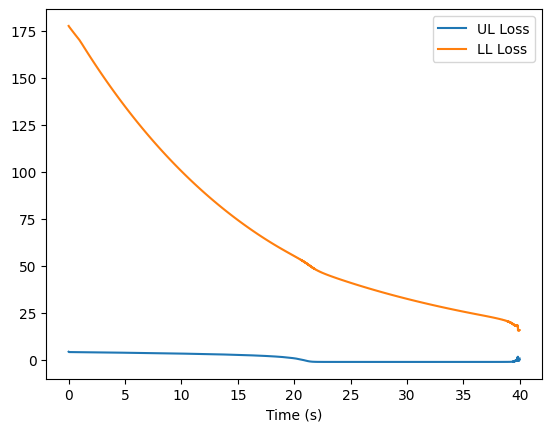

In [78]:
timeSteps = np.arange(0, len(errors[0]) * deltaT, deltaT)


plt.plot(timeSteps, errors[0], label='UL Loss')
plt.plot(timeSteps, errors[1], label='LL Loss')

plt.xlabel('Time (s)')
plt.legend()
plt.show()

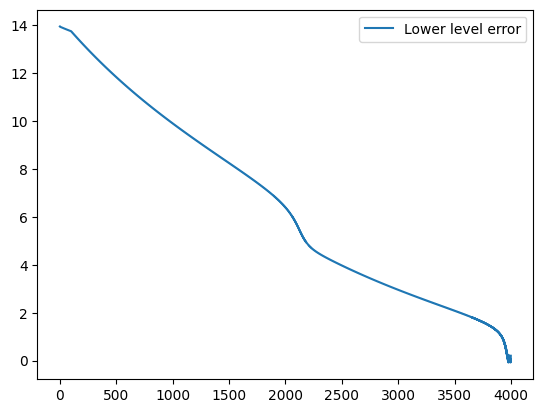

In [79]:
plt.plot(errors[2], label='Lower level error')

# plt.yscale('log')
plt.legend()
plt.show()

In [80]:
(A@x + H@y)

tensor([[-0.2613],
        [ 0.0922],
        [-0.1529],
        [-1.0781],
        [-0.0243],
        [-0.2211],
        [ 0.0566],
        [ 1.0889],
        [-0.5205],
        [ 0.4988],
        [ 0.1191],
        [ 0.8575],
        [-0.1751],
        [-0.0194],
        [-0.7506],
        [ 0.6175],
        [-0.6752],
        [ 0.2614],
        [-0.5453],
        [-0.7054],
        [-0.0691],
        [ 0.7811],
        [ 0.3111],
        [-0.4250],
        [-0.5549],
        [-0.2067],
        [-0.9524],
        [-0.0461],
        [-0.1366],
        [ 0.1830],
        [ 0.2305],
        [-0.0081],
        [ 0.4098],
        [ 0.3340],
        [-0.7356],
        [-0.5339],
        [ 1.6553],
        [ 0.5790],
        [-0.2579],
        [-0.0349],
        [-0.7640],
        [ 0.9210],
        [ 0.0115],
        [ 0.3353],
        [ 0.7401],
        [ 0.2645],
        [ 0.2183],
        [-0.1198],
        [-0.7999],
        [ 0.2791],
        [-0.0252],
        [-1.0517],
        [ 0.